# Formulação 2 - Estudo Experimental

In [25]:
%run ../src/feature_engineering.py
%run ../src/model_evaluation.py
%run ../src/plot.py
%run ../src/pipeline.py

import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras import models
from keras.utils import to_categorical
from keras import layers
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, precision_score,f1_score, recall_score

%matplotlib inline
#Alterando configurações padrão dos plots
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (20, 160)

In [2]:
course_df = pd.read_csv('../data/preprocessed/preprocessed_edx_2014_enriched.csv',low_memory=False)

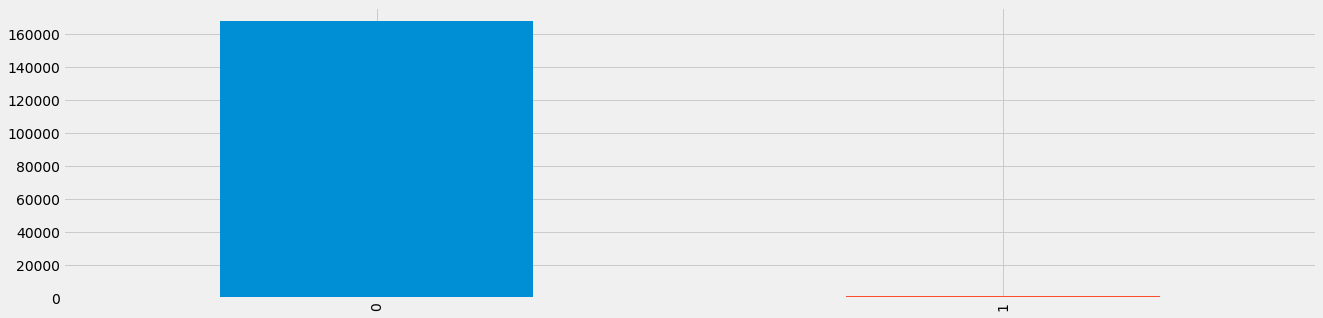

In [16]:
plt.rcParams['figure.figsize'] = (20, 5)
cs50x = course_df[course_df['course_id']=='CS50x']
cs50x['certified'].value_counts(sort=True).plot.bar()

## Divisão dos Dados Em Cenários

In [7]:
course_df['course_year'] =  course_df['course_id'].astype(str) +'_'+course_df['year'].astype(str)
course_years = course_df['course_year'].unique()
#random.shuffle(course_years)
course_years = ['PH278x_2013', '8.MReV_2013', 'CS50x_2012','7.00x_2013',
                '8.02x_2013',  '3.091x_2013', 'ER22x_2013','14.73x_2013',
                'PH207x_2012', '6.00x_2012', '3.091x_2012', '2.01x_2013',
                 'CB22x_2013', '6.00x_2013', '6.002x_2012',  '6.002x_2013']

# Cenário de Análise Sem Eliminar linhas Inconsistentes
cen1 = course_years[0:5] 
# Cenário de Análise Eliminando linhas Inconsistentes
cen2 = course_years[5:10]
# Cenário de Análise Utilizando apenas as variáveis selecionadas.
cen3 = course_years[10:15]


cen1df = course_df[course_df['course_year'].isin(cen1)]
cen2df = course_df[course_df['course_year'].isin(cen2)]
cen3df = course_df[course_df['course_year'].isin(cen3)]  

In [8]:
print(cen1df.shape, cen2df.shape, cen3df.shape)

(270757, 35) (199738, 35) (148408, 35)


### Cenário 2 | Removendo Linhas com Grade Nulo ou Inconsistentes

In [9]:
#cen2df = cen2df.dropna(subset=['grade'])
cen2df = cen2df[cen2df['incomplete_flag']!=1]
print(cen1df.shape, cen2df.shape, cen3df.shape)

(270757, 35) (192693, 35) (148408, 35)


### Cenário 3 | Identificando as variáveis correlacionadas à solução

In [ ]:
related  = feature_extract(course_df.sample(100000))
related.head()

In [ ]:
related.columns

In [ ]:
import statsmodels.api as sm
from scipy import stats
import sklearn.preprocessing

In [ ]:

XBase, y = related.loc[:, related.columns != 'grade'], related['grade']
X =  preprocessing.normalize(XBase)
print(X.shape, y.shape)


In [ ]:
X2 = sm.add_constant(X)
est = sm.OLS(np.asarray(y, dtype='float'), np.asarray(X2, dtype='float'))
r = est.fit()

r2 = r.f_test()
r2.summary()
#pd.options.display.float_format = '{:,.10f}'.format
#for i,c in enumerate(XBase.columns):
#    print(i, c, "{0:0.4f}".format(r.pvalues[i]))
    
#pd.DataFrame(r.pvalues)
#X2

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn import feature_selection

model = SelectKBest(score_func=feature_selection.mutual_info_regression, k=20)
r = model.fit(X, y)

print(r.scores_)
print(r.pvalues_)

pd.options.display.float_format = '{:,.10f}'.format
for i,c in enumerate(XBase.columns):
    print(i, c, "{0:0.4f}".format(r.scores_[i]))
    
#pd.DataFrame(r.pvalues)
#X2

## Formulação 1
### Cenário 1

In [22]:
plt.rcParams.update({'font.size': 8})


class ModelDecorator:
    def __init__(self, model):
        self._model = model
        
    def fit(self, X, y):
        #from sklearn.utils import class_weight
        #class_weights = class_weight.compute_class_weight('balanced',np.unique(y), y)
        #print(class_weights)
        #y = to_categorical(y)       
        #return self._model.fit(X, y, epochs=12, class_weight=class_weights, verbose=1)
        return self._model.fit(X, y, epochs=20, verbose=0)
    
    def predict(self, X):
        #return flatten(self._model.predict(X))
        pred = self._model.predict(X)
        return  [ 1 if p>=0.5 else 0 for p in pred]
   

class _DeepLearning:
    def __init__(self, input_dim=21):
        self._input_dim = input_dim
        
    def provide(self):
        # create model
        model = models.Sequential()
        model.add(layers.Dense(self._input_dim*2, input_dim= self._input_dim, activation='relu'))
        model.add(layers.Dense(self._input_dim, input_dim= self._input_dim, activation='relu'))
        model.add(layers.Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
        return ModelDecorator(model)
    
    def sample_size(self):
        return None    
     
    def require_balance(self):
        return True

class _RandonForest:
    def provide(self):
        return Pipeline([('scaler', StandardScaler()),
                  ('rfr',RandomForestClassifier(n_jobs=2, random_state=42))])
    
    def sample_size(self):
        return None
     
    def require_balance(self):
        return False

class _SuppotVectorMachine:
    def provide(self):
        return Pipeline([('scaler', StandardScaler()),
                  ('poly',SVC(random_state=42))])
    
    def sample_size(self):
        return None
     
    def require_balance(self):
        return False

class _LogisticRegression:
    def provide(self):
        return Pipeline([('scaler', StandardScaler()),
                  ('poly',LogisticRegression(solver='sag', random_state=42))])
    
    def sample_size(self):
        return None
     
    def require_balance(self):
        return False


class _NaiveBayes:
    def provide(self):
        return Pipeline([('scaler', StandardScaler()),
                  ('nb',GaussianNB())])
    
    def sample_size(self):
        return None   
     
    def require_balance(self):
        return False 
   
_models = [
    _LogisticRegression()    ,
    _DeepLearning(),
    _RandonForest(),
    _SuppotVectorMachine(),
    _NaiveBayes()
]

def feature_extract_certified(data):
    return feature_extract(data, target='certified')


def evaluate(y_pred, y_test):
    return {'f1': f1_score(y_test, y_pred),
            'accuracy':accuracy_score(y_test, y_pred),
            'precision':precision_score(y_test, y_pred),
           'recall_score':recall_score(y_test, y_pred)}



results1, plt, models = train_evaluate(_models, cen1df, feature_extractor= feature_extract_certified, 
                              label='certified', split_criteria='course_id', evaluation=evaluate, 
                              plots= [], plot_enabled=False, balance=True)


2018-06-21 23:48:43 Iniciando modelo _LogisticRegression
2018-06-21 23:48:43 Iniciando curso CS50x
(169621, 35)


D:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


2018-06-21 23:49:05 Treinamento OK!
2018-06-21 23:49:05 Resultados {'f1': 0.5950054288816504, 'accuracy': 0.9945024171677869, 'precision': 0.7043701799485861, 'recall_score': 0.5150375939849624, 'train_time': 236999, 'test_time': 34000, 'n_test': 67848, 'n_train': 101773}
2018-06-21 23:49:05 Iniciando curso PH278x
(39602, 35)


D:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


2018-06-21 23:49:09 Treinamento OK!
2018-06-21 23:49:09 Resultados {'f1': 0.7013487475915221, 'accuracy': 0.9902152641878669, 'precision': 0.7193675889328063, 'recall_score': 0.6842105263157895, 'train_time': 93001, 'test_time': 7997, 'n_test': 15841, 'n_train': 23761}
2018-06-21 23:49:09 Iniciando curso 7.00x
(21009, 35)


D:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


2018-06-21 23:49:12 Treinamento OK!
2018-06-21 23:49:12 Resultados {'f1': 0.7874999999999999, 'accuracy': 0.9838172298905283, 'precision': 0.7567567567567568, 'recall_score': 0.8208469055374593, 'train_time': 508004, 'test_time': 4999, 'n_test': 8404, 'n_train': 12605}
2018-06-21 23:49:12 Iniciando curso 8.02x
(31048, 35)


D:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


2018-06-21 23:49:15 Treinamento OK!
2018-06-21 23:49:15 Resultados {'f1': 0.8693098384728339, 'accuracy': 0.9928335614783799, 'precision': 0.8731563421828908, 'recall_score': 0.8654970760233918, 'train_time': 794029, 'test_time': 6001, 'n_test': 12419, 'n_train': 18629}
2018-06-21 23:49:15 Iniciando curso 8.MReV
(9477, 35)


D:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


2018-06-21 23:49:16 Treinamento OK!
2018-06-21 23:49:16 Resultados {'f1': 0.7715355805243446, 'accuracy': 0.9839092587707728, 'precision': 0.7518248175182481, 'recall_score': 0.7923076923076923, 'train_time': 219036, 'test_time': 1978, 'n_test': 3791, 'n_train': 5686}
2018-06-21 23:49:16 Iniciando modelo _DeepLearning
2018-06-21 23:49:16 Iniciando curso CS50x
(169621, 35)
1219 159921
2018-06-21 23:49:34 Treinamento OK!
2018-06-21 23:49:37 Resultados {'f1': 0.06844919786096258, 'accuracy': 0.9895802802916565, 'precision': 0.03551609322974473, 'recall_score': 0.9411764705882353, 'train_time': 619456, 'test_time': 191999, 'n_test': 167183, 'n_train': 2438}
2018-06-21 23:49:37 Iniciando curso PH278x
(39602, 35)
675 36947
2018-06-21 23:49:43 Treinamento OK!
2018-06-21 23:49:44 Resultados {'f1': 0.04371584699453552, 'accuracy': 0.9588256823172645, 'precision': 0.0223463687150838, 'recall_score': 1.0, 'train_time': 930999, 'test_time': 38000, 'n_test': 38252, 'n_train': 1350}
2018-06-21 23:49

D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2018-06-21 23:49:54 Resultados {'f1': 0.0, 'accuracy': 0.9986433319766653, 'precision': 0.0, 'recall_score': 0.0, 'train_time': 159715, 'test_time': 28001, 'n_test': 29484, 'n_train': 1564}
2018-06-21 23:49:54 Iniciando curso 8.MReV
(9477, 35)
282 8721
2018-06-21 23:49:56 Treinamento OK!
2018-06-21 23:49:57 Resultados {'f1': 0.0, 'accuracy': 0.9983170649612925, 'precision': 0.0, 'recall_score': 0.0, 'train_time': 421956, 'test_time': 10004, 'n_test': 8913, 'n_train': 564}
2018-06-21 23:49:57 Iniciando modelo _RandonForest
2018-06-21 23:49:57 Iniciando curso CS50x
(169621, 35)
2018-06-21 23:50:14 Treinamento OK!
2018-06-21 23:50:14 Resultados {'f1': 0.6153846153846153, 'accuracy': 0.994694021931376, 'precision': 0.7128712871287128, 'recall_score': 0.5413533834586466, 'train_time': 304999, 'test_time': 38001, 'n_test': 67848, 'n_train': 101773}
2018-06-21 23:50:14 Iniciando curso PH278x
(39602, 35)
2018-06-21 23:50:18 Treinamento OK!
2018-06-21 23:50:18 Resultados {'f1': 0.71172962226640

In [23]:
results1

{'_DeepLearning': {'7.00x': {'accuracy': 0.8778343359555761,
   'f1': 0.034930950446791224,
   'n_test': 19449,
   'n_train': 1560,
   'precision': 0.017775940471269118,
   'recall_score': 1.0,
   'test_time': 20001,
   'train_time': 32998},
  '8.02x': {'accuracy': 0.9986433319766653,
   'f1': 0.0,
   'n_test': 29484,
   'n_train': 1564,
   'precision': 0.0,
   'recall_score': 0.0,
   'test_time': 28001,
   'train_time': 159715},
  '8.MReV': {'accuracy': 0.9983170649612925,
   'f1': 0.0,
   'n_test': 8913,
   'n_train': 564,
   'precision': 0.0,
   'recall_score': 0.0,
   'test_time': 10004,
   'train_time': 421956},
  'CS50x': {'accuracy': 0.9895802802916565,
   'f1': 0.06844919786096258,
   'n_test': 167183,
   'n_train': 2438,
   'precision': 0.03551609322974473,
   'recall_score': 0.9411764705882353,
   'test_time': 191999,
   'train_time': 619456},
  'PH278x': {'accuracy': 0.9588256823172645,
   'f1': 0.04371584699453552,
   'n_test': 38252,
   'n_train': 1350,
   'precision': 0.0

### Cenário 2


In [26]:
results2, plt, model = train_evaluate(_models, cen2df, feature_extractor= feature_extract_certified, 
                              label='certified', split_criteria='course_id', evaluation=evaluate, 
                              plots= [], plot_enabled=False, balance=True)

2018-06-21 23:53:58 Iniciando modelo _LogisticRegression
2018-06-21 23:53:58 Iniciando curso PH207x
(41271, 35)


D:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


2018-06-21 23:54:03 Treinamento OK!
2018-06-21 23:54:03 Resultados {'f1': 0.7174211248285322, 'accuracy': 0.9750424036830627, 'precision': 0.7418439716312056, 'recall_score': 0.6945551128818062, 'train_time': 109004, 'test_time': 9006, 'n_test': 16508, 'n_train': 24763}
2018-06-21 23:54:03 Iniciando curso ER22x
(54721, 35)


D:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


2018-06-21 23:54:10 Treinamento OK!
2018-06-21 23:54:10 Resultados {'f1': 0.7279029462738302, 'accuracy': 0.9784813596491229, 'precision': 0.8066581306017926, 'recall_score': 0.6631578947368421, 'train_time': 837000, 'test_time': 9966, 'n_test': 21888, 'n_train': 32833}
2018-06-21 23:54:10 Iniciando curso 6.00x
(66151, 35)


D:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


2018-06-21 23:54:18 Treinamento OK!
2018-06-21 23:54:18 Resultados {'f1': 0.8785894206549119, 'accuracy': 0.9908919123204838, 'precision': 0.8659384309831182, 'recall_score': 0.8916155419222904, 'train_time': 78002, 'test_time': 13996, 'n_test': 26460, 'n_train': 39691}
2018-06-21 23:54:18 Iniciando curso 3.091x
(5358, 35)


D:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


2018-06-21 23:54:18 Treinamento OK!
2018-06-21 23:54:18 Resultados {'f1': 0.8380952380952381, 'accuracy': 0.9920671955202987, 'precision': 0.88, 'recall_score': 0.8, 'train_time': 121037, 'test_time': 1995, 'n_test': 2143, 'n_train': 3215}
2018-06-21 23:54:18 Iniciando curso 14.73x
(25192, 35)


D:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


2018-06-21 23:54:21 Treinamento OK!
2018-06-21 23:54:21 Resultados {'f1': 0.915606936416185, 'accuracy': 0.9855115609804506, 'precision': 0.9030786773090079, 'recall_score': 0.9284876905041032, 'train_time': 654969, 'test_time': 5998, 'n_test': 10077, 'n_train': 15115}
2018-06-21 23:54:21 Iniciando modelo _DeepLearning
2018-06-21 23:54:21 Iniciando curso PH207x
(41271, 35)
1735 37472
2018-06-21 23:54:28 Treinamento OK!


D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Programs\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2018-06-21 23:54:29 Resultados {'f1': 0.0, 'accuracy': 0.9971958413798577, 'precision': 0.0, 'recall_score': 0.0, 'train_time': 317570, 'test_time': 35001, 'n_test': 37801, 'n_train': 3470}
2018-06-21 23:54:29 Iniciando curso ER22x
(54721, 35)
2249 49736
2018-06-21 23:54:38 Treinamento OK!
2018-06-21 23:54:39 Resultados {'f1': 0.04534606205250597, 'accuracy': 0.9203552157378093, 'precision': 0.0231990231990232, 'recall_score': 1.0, 'train_time': 14000, 'test_time': 48033, 'n_test': 50223, 'n_train': 4498}
2018-06-21 23:54:39 Iniciando curso 6.00x
(66151, 35)
2340 60503
2018-06-21 23:54:49 Treinamento OK!
2018-06-21 23:54:50 Resultados {'f1': 0.0, 'accuracy': 0.9978038424622993, 'precision': 0.0, 'recall_score': 0.0, 'train_time': 170821, 'test_time': 56004, 'n_test': 61471, 'n_train': 4680}
2018-06-21 23:54:50 Iniciando curso 3.091x
(5358, 35)
135 4955
2018-06-21 23:54:52 Treinamento OK!
2018-06-21 23:54:53 Resultados {'f1': 0.0052677787532923615, 'accuracy': 0.7773191823899371, 'preci

In [27]:
results2

{'_DeepLearning': {'14.73x': {'accuracy': 0.9483667513884967,
   'f1': 0.16577946768060833,
   'n_test': 21246,
   'n_train': 3946,
   'precision': 0.09053156146179402,
   'recall_score': 0.9819819819819819,
   'test_time': 21001,
   'train_time': 795967},
  '3.091x': {'accuracy': 0.7773191823899371,
   'f1': 0.0052677787532923615,
   'n_test': 5088,
   'n_train': 270,
   'precision': 0.002640845070422535,
   'recall_score': 1.0,
   'test_time': 6002,
   'train_time': 233999},
  '6.00x': {'accuracy': 0.9978038424622993,
   'f1': 0.0,
   'n_test': 61471,
   'n_train': 4680,
   'precision': 0.0,
   'recall_score': 0.0,
   'test_time': 56004,
   'train_time': 170821},
  'ER22x': {'accuracy': 0.9203552157378093,
   'f1': 0.04534606205250597,
   'n_test': 50223,
   'n_train': 4498,
   'precision': 0.0231990231990232,
   'recall_score': 1.0,
   'test_time': 48033,
   'train_time': 14000},
  'PH207x': {'accuracy': 0.9971958413798577,
   'f1': 0.0,
   'n_test': 37801,
   'n_train': 3470,
   'p

### Cenário 3

In [29]:
def feat_extract_selected(df):
    data=feature_extract(df, target='certified')
    return data[['certified',
                'LoE_DI',
                'viewed',
                'explored',
                'YoB',
                'duration',
                'ndays_act',
                'nplay_video',
                'nchapters']]


_models = [
    _LogisticRegression()    ,
    _DeepLearning(8),
    _RandonForest(),
    _SuppotVectorMachine(),
    _NaiveBayes()
]



results3, plt, _ = train_evaluate(_models, cen3df, feature_extractor= feat_extract_selected, 
                              label='certified', split_criteria='course_id', evaluation=evaluate, 
                              plots= [], plot_enabled=False, balance=True)
plt.show()




2018-06-21 23:59:35 Iniciando modelo _LogisticRegression
2018-06-21 23:59:35 Iniciando curso CB22x
(30002, 35)


D:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


2018-06-21 23:59:38 Treinamento OK!
2018-06-21 23:59:38 Resultados {'f1': 0.8662420382165605, 'accuracy': 0.9965002916423631, 'precision': 0.8143712574850299, 'recall_score': 0.9251700680272109, 'train_time': 515964, 'test_time': 8032, 'n_test': 12001, 'n_train': 18001}
2018-06-21 23:59:38 Iniciando curso 6.002x
(40811, 35)


D:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


2018-06-21 23:59:43 Treinamento OK!
2018-06-21 23:59:43 Resultados {'f1': 0.8226363008971703, 'accuracy': 0.9842563097280078, 'precision': 0.7770534550195567, 'recall_score': 0.873900293255132, 'train_time': 713997, 'test_time': 11996, 'n_test': 16324, 'n_train': 24487}
2018-06-21 23:59:43 Iniciando curso 2.01x
(5665, 35)


D:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


2018-06-21 23:59:43 Treinamento OK!
2018-06-21 23:59:43 Resultados {'f1': 0.7909604519774012, 'accuracy': 0.9836716681376876, 'precision': 0.7954545454545454, 'recall_score': 0.7865168539325843, 'train_time': 87995, 'test_time': 3029, 'n_test': 2266, 'n_train': 3399}
2018-06-21 23:59:43 Iniciando curso 3.091x
(14215, 35)


D:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


2018-06-21 23:59:45 Treinamento OK!
2018-06-21 23:59:45 Resultados {'f1': 0.9124087591240876, 'accuracy': 0.9915582131551178, 'precision': 0.8771929824561403, 'recall_score': 0.9505703422053232, 'train_time': 235993, 'test_time': 3998, 'n_test': 5686, 'n_train': 8529}
2018-06-21 23:59:45 Iniciando curso 6.00x
(57715, 35)


D:\Programs\Anaconda\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


2018-06-21 23:59:51 Treinamento OK!
2018-06-21 23:59:51 Resultados {'f1': 0.8532778355879291, 'accuracy': 0.9938924023217535, 'precision': 0.8836206896551724, 'recall_score': 0.8249496981891348, 'train_time': 83963, 'test_time': 10999, 'n_test': 23086, 'n_train': 34629}
2018-06-21 23:59:51 Iniciando modelo _DeepLearning
2018-06-21 23:59:51 Iniciando curso CB22x
(30002, 35)
370 28132
2018-06-21 23:59:56 Treinamento OK!
2018-06-21 23:59:57 Resultados {'f1': 0.07387862796833773, 'accuracy': 0.9880049210580275, 'precision': 0.038356164383561646, 'recall_score': 1.0, 'train_time': 808031, 'test_time': 28032, 'n_test': 29262, 'n_train': 740}
2018-06-21 23:59:57 Iniciando curso 6.002x
(40811, 35)
1662 37108
2018-06-22 00:00:04 Treinamento OK!
2018-06-22 00:00:05 Resultados {'f1': 0.12888888888888891, 'accuracy': 0.9686291247632512, 'precision': 0.06893819334389857, 'recall_score': 0.9886363636363636, 'train_time': 645966, 'test_time': 37004, 'n_test': 37487, 'n_train': 3324}
2018-06-22 00:00:

In [30]:
results3

{'_DeepLearning': {'2.01x': {'accuracy': 0.8201424995185828,
   'f1': 0.023012552301255228,
   'n_test': 5193,
   'n_train': 472,
   'precision': 0.01164021164021164,
   'recall_score': 1.0,
   'test_time': 6994,
   'train_time': 910449},
  '3.091x': {'accuracy': 0.9695735689588936,
   'f1': 0.1391304347826087,
   'n_test': 13015,
   'n_train': 1200,
   'precision': 0.07476635514018691,
   'recall_score': 1.0,
   'test_time': 14003,
   'train_time': 308965},
  '6.002x': {'accuracy': 0.9686291247632512,
   'f1': 0.12888888888888891,
   'n_test': 37487,
   'n_train': 3324,
   'precision': 0.06893819334389857,
   'recall_score': 0.9886363636363636,
   'test_time': 37004,
   'train_time': 645966},
  '6.00x': {'accuracy': 0.958976860131144,
   'f1': 0.061957868649318466,
   'n_test': 55359,
   'n_train': 2356,
   'precision': 0.0319693094629156,
   'recall_score': 1.0,
   'test_time': 60039,
   'train_time': 538401},
  'CB22x': {'accuracy': 0.9880049210580275,
   'f1': 0.07387862796833773,
